In [174]:
import pandas as pd
import numpy as np
from surprise import Reader
from surprise import Dataset
from surprise import dataset
from surprise.model_selection import cross_validate
from surprise import NormalPredictor
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNWithZScore
from surprise import KNNBaseline
from surprise import SVD
from surprise import BaselineOnly
from surprise import SVDpp
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering
from surprise.accuracy import rmse
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
%matplotlib inline

In [176]:
train_df = pd.read_csv("train.dat", header = None, names = ['UserID', 'ItemID', 'Rating', 'Timestamp'], sep = '\t')
train_df.drop(['Timestamp'], axis=1, inplace=True)
train_df

,UserID,ItemID,Rating
0,905,470,1
1,697,1518,5
2,855,1687,5
3,950,1447,5
4,806,1170,4
...,...,...,...
85719,205,1136,1
85720,708,1497,4
85721,167,1036,3
85722,508,1528,3


In [177]:
test_df = pd.read_csv("test.dat", header = None, names = ['UserID', 'ItemID'], sep = '\t')
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2154 entries, 0 to 2153
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   UserID  2154 non-null   int64
 1   ItemID  2154 non-null   int64
dtypes: int64(2)
memory usage: 33.8 KB


In [178]:
train_df.groupby('ItemID')['Rating'].mean().sort_values(ascending=False).head()

ItemID
499    5.0
407    5.0
394    5.0
233    5.0
164    5.0
Name: Rating, dtype: float64

In [179]:
train_df.groupby('ItemID')['Rating'].count().sort_values(ascending=False).head()

ItemID
1650    497
1442    427
1519    427
1600    425
1412    417
Name: Rating, dtype: int64

In [187]:
train_df.groupby('UserID')['Rating'].count().sort_values(ascending=False).head()

UserID
595    686
345    594
987    555
550    508
584    457
Name: Rating, dtype: int64

In [180]:
ratings = pd.DataFrame(train_df.groupby('ItemID')['Rating'].mean())
ratings.head()

,Rating
ItemID,
20,2.0
21,3.0
22,1.0
23,3.0
24,2.0


In [191]:
ratings1 = pd.DataFrame(train_df.groupby('UserID')['Rating'].mean().sort_values(ascending=False).head())
ratings1.head()

,Rating
UserID,
151,4.888889
312,4.818182
372,4.720000
493,4.687500
882,4.661290


In [181]:
ratings['NumofRatings'] = pd.DataFrame(train_df.groupby('ItemID')['Rating'].count())
ratings.head()

,Rating,NumofRatings
ItemID,,
20,2.0,1
21,3.0,1
22,1.0,1
23,3.0,1
24,2.0,1


<AxesSubplot:>

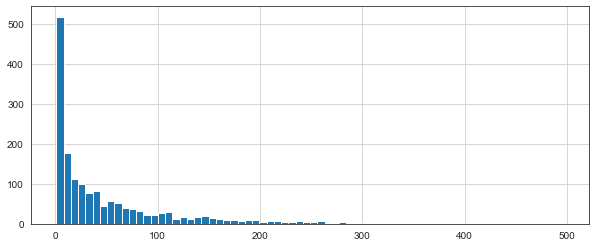

In [182]:
plt.figure(figsize=(10,4))
ratings['NumofRatings'].hist(bins=70)

<AxesSubplot:>

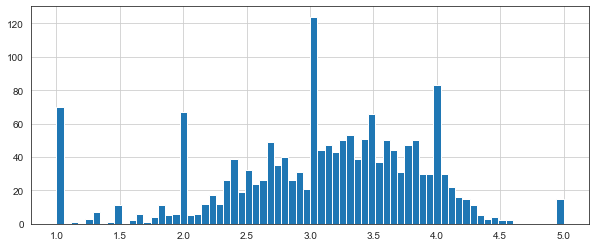

In [183]:
plt.figure(figsize=(10,4))
ratings['Rating'].hist(bins=70)

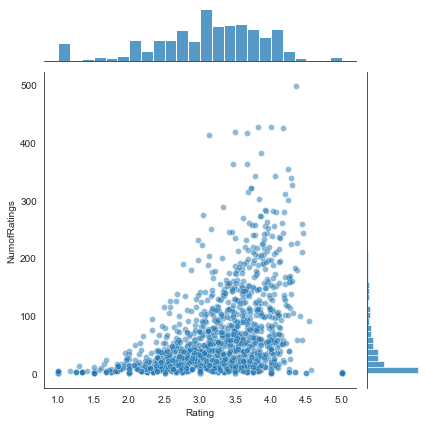

In [184]:
sns.jointplot(x='Rating',y='NumofRatings',data=ratings,alpha=0.5)

In [185]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(train_df[['UserID', 'ItemID', 'Rating']], reader)

In [186]:
benchmark = []
# Iterate over all algorithms

algorithms = [SVD(), SVDpp(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]

print ("Attempting: ", str(algorithms), '\n\n\n')

for algorithm in algorithms:
    print("Starting: " ,str(algorithm))
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
    # results = cross_validate(algorithm, data, measures=['RMSE','MAE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    print("Done: " ,str(algorithm), "\n\n")

print ('\n\tDONE\n')

Attempting:  [<surprise.prediction_algorithms.matrix_factorization.SVD object at 0x0000015C3EAB7400>, <surprise.prediction_algorithms.matrix_factorization.SVDpp object at 0x0000015C3EAB7370>, <surprise.prediction_algorithms.slope_one.SlopeOne object at 0x0000015C3EAB71C0>, <surprise.prediction_algorithms.matrix_factorization.NMF object at 0x0000015C3EAB7130>, <surprise.prediction_algorithms.random_pred.NormalPredictor object at 0x0000015C3EAB74C0>, <surprise.prediction_algorithms.knns.KNNBaseline object at 0x0000015C3C7DCC40>, <surprise.prediction_algorithms.knns.KNNBasic object at 0x0000015C3EBD74C0>, <surprise.prediction_algorithms.knns.KNNWithMeans object at 0x0000015C3C7D3340>, <surprise.prediction_algorithms.knns.KNNWithZScore object at 0x0000015C3E8DEDC0>, <surprise.prediction_algorithms.baseline_only.BaselineOnly object at 0x0000015C3EAAB1C0>, <surprise.prediction_algorithms.co_clustering.CoClustering object at 0x0000015C3C8139A0>] 



Starting:  <surprise.prediction_algorithms.

In [142]:
surprise_results = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')

In [143]:
surprise_results

,test_rmse,fit_time,test_time
Algorithm,,,
SVDpp,0.933328,112.691523,3.524218
KNNBaseline,0.940745,0.468465,5.050569
BaselineOnly,0.950452,0.226177,0.271529
SVD,0.952169,3.742409,0.403681
SlopeOne,0.954150,0.414259,2.713668
KNNWithMeans,0.962369,0.365869,4.644054
KNNWithZScore,0.962999,0.411534,4.942302
NMF,0.984970,4.443949,0.286411
CoClustering,0.985725,2.077911,0.275899


In [173]:
param_grid = {'k': list(range(10,45,3)),
              'sim_options' : {'name': ['cosine', 'pearson_baseline', 'pearson', 'msd'],
                             'user_based': [False, True], 
                             'min_support': [5] 
                            }
             }
gs = GridSearchCV(KNNBaseline, param_grid, measures=['rmse', 'mae'], cv=5)

gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])



Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Comput

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine 

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matr

Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done 

Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity ma

Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
D

Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computin

In [192]:
algo = gs.best_estimator['rmse']
algo.fit(data.build_full_trainset())

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [193]:
formatfile = open('format.dat', "w")
predictions = []
uid = [u for u in test_df['UserID']]
iid = [i for i in test_df['ItemID']]
for p in range(len(test_df)):
    pred = algo.predict(uid[p], iid[p], verbose = True)
    predictions = round(pred.est,2)
    pred_file = str(predictions)+"\n"
    print(pred_file)
    formatfile.write(pred_file)

user: 158        item: 951        r_ui = None   est = 3.30   {'actual_k': 5, 'was_impossible': False}
3.3

user: 521        item: 1202       r_ui = None   est = 3.66   {'actual_k': 37, 'was_impossible': False}
3.66

user: 98         item: 1556       r_ui = None   est = 3.65   {'actual_k': 16, 'was_impossible': False}
3.65

user: 292        item: 1583       r_ui = None   est = 3.71   {'actual_k': 37, 'was_impossible': False}
3.71

user: 68         item: 1064       r_ui = None   est = 3.76   {'actual_k': 37, 'was_impossible': False}
3.76

user: 881        item: 1208       r_ui = None   est = 4.19   {'actual_k': 37, 'was_impossible': False}
4.19

user: 777        item: 881        r_ui = None   est = 2.72   {'actual_k': 37, 'was_impossible': False}
2.72

user: 231        item: 1463       r_ui = None   est = 3.28   {'actual_k': 17, 'was_impossible': False}
3.28

user: 549        item: 813        r_ui = None   est = 2.85   {'actual_k': 35, 'was_impossible': False}
2.85

user: 122        item

user: 267        item: 1424       r_ui = None   est = 3.55   {'actual_k': 37, 'was_impossible': False}
3.55

user: 61         item: 1417       r_ui = None   est = 4.58   {'actual_k': 8, 'was_impossible': False}
4.58

user: 161        item: 1594       r_ui = None   est = 2.53   {'actual_k': 19, 'was_impossible': False}
2.53

user: 123        item: 1527       r_ui = None   est = 4.43   {'actual_k': 28, 'was_impossible': False}
4.43

user: 304        item: 801        r_ui = None   est = 3.65   {'actual_k': 0, 'was_impossible': False}
3.65

user: 97         item: 1688       r_ui = None   est = 4.49   {'actual_k': 37, 'was_impossible': False}
4.49

user: 628        item: 1436       r_ui = None   est = 3.75   {'actual_k': 29, 'was_impossible': False}
3.75

user: 494        item: 1501       r_ui = None   est = 4.70   {'actual_k': 37, 'was_impossible': False}
4.7

user: 130        item: 1001       r_ui = None   est = 3.48   {'actual_k': 37, 'was_impossible': False}
3.48

user: 106        item:

user: 811        item: 546        r_ui = None   est = 3.91   {'actual_k': 26, 'was_impossible': False}
3.91

user: 193        item: 1190       r_ui = None   est = 4.07   {'actual_k': 37, 'was_impossible': False}
4.07

user: 993        item: 1093       r_ui = None   est = 4.24   {'actual_k': 37, 'was_impossible': False}
4.24

user: 404        item: 1411       r_ui = None   est = 3.21   {'actual_k': 6, 'was_impossible': False}
3.21

user: 463        item: 1319       r_ui = None   est = 3.10   {'actual_k': 37, 'was_impossible': False}
3.1

user: 115        item: 1606       r_ui = None   est = 3.15   {'actual_k': 37, 'was_impossible': False}
3.15

user: 505        item: 437        r_ui = None   est = 3.43   {'actual_k': 37, 'was_impossible': False}
3.43

user: 383        item: 384        r_ui = None   est = 2.38   {'actual_k': 0, 'was_impossible': False}
2.38

user: 219        item: 1650       r_ui = None   est = 4.69   {'actual_k': 22, 'was_impossible': False}
4.69

user: 126        item:

user: 455        item: 1158       r_ui = None   est = 2.97   {'actual_k': 37, 'was_impossible': False}
2.97

user: 249        item: 1214       r_ui = None   est = 4.06   {'actual_k': 37, 'was_impossible': False}
4.06

user: 84         item: 1048       r_ui = None   est = 3.79   {'actual_k': 37, 'was_impossible': False}
3.79

user: 196        item: 770        r_ui = None   est = 3.21   {'actual_k': 37, 'was_impossible': False}
3.21

user: 75         item: 1602       r_ui = None   est = 4.51   {'actual_k': 9, 'was_impossible': False}
4.51

user: 284        item: 1206       r_ui = None   est = 3.87   {'actual_k': 37, 'was_impossible': False}
3.87

user: 278        item: 877        r_ui = None   est = 3.01   {'actual_k': 19, 'was_impossible': False}
3.01

user: 73         item: 925        r_ui = None   est = 3.21   {'actual_k': 20, 'was_impossible': False}
3.21

user: 115        item: 1650       r_ui = None   est = 4.28   {'actual_k': 37, 'was_impossible': False}
4.28

user: 721        ite

user: 779        item: 1583       r_ui = None   est = 3.79   {'actual_k': 37, 'was_impossible': False}
3.79

user: 101        item: 1343       r_ui = None   est = 4.11   {'actual_k': 37, 'was_impossible': False}
4.11

user: 564        item: 1689       r_ui = None   est = 4.29   {'actual_k': 37, 'was_impossible': False}
4.29

user: 72         item: 1528       r_ui = None   est = 4.43   {'actual_k': 10, 'was_impossible': False}
4.43

user: 707        item: 1290       r_ui = None   est = 2.82   {'actual_k': 37, 'was_impossible': False}
2.82

user: 388        item: 1675       r_ui = None   est = 3.81   {'actual_k': 8, 'was_impossible': False}
3.81

user: 840        item: 1375       r_ui = None   est = 3.13   {'actual_k': 37, 'was_impossible': False}
3.13

user: 196        item: 1054       r_ui = None   est = 3.92   {'actual_k': 37, 'was_impossible': False}
3.92

user: 84         item: 1275       r_ui = None   est = 3.78   {'actual_k': 37, 'was_impossible': False}
3.78

user: 733        ite

user: 906        item: 979        r_ui = None   est = 3.44   {'actual_k': 37, 'was_impossible': False}
3.44

user: 73         item: 1422       r_ui = None   est = 3.34   {'actual_k': 25, 'was_impossible': False}
3.34

user: 66         item: 1601       r_ui = None   est = 3.82   {'actual_k': 37, 'was_impossible': False}
3.82

user: 103        item: 1660       r_ui = None   est = 3.24   {'actual_k': 37, 'was_impossible': False}
3.24

user: 471        item: 1011       r_ui = None   est = 3.59   {'actual_k': 19, 'was_impossible': False}
3.59

user: 293        item: 1196       r_ui = None   est = 3.74   {'actual_k': 37, 'was_impossible': False}
3.74

user: 63         item: 1650       r_ui = None   est = 4.24   {'actual_k': 13, 'was_impossible': False}
4.24

user: 113        item: 1650       r_ui = None   est = 4.76   {'actual_k': 37, 'was_impossible': False}
4.76

user: 222        item: 1454       r_ui = None   est = 3.49   {'actual_k': 22, 'was_impossible': False}
3.49

user: 146        it